In [1]:
%matplotlib inline

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# NuScenes api
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/home/samliu/code/ds2020-final-project/nuscenes_dataset/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.451 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
for index_scene, scene_dict in enumerate(nusc.scene):
    print(scene_dict['name'])

scene-0061
scene-0103
scene-0553
scene-0655
scene-0757
scene-0796
scene-0916
scene-1077
scene-1094
scene-1100


In [3]:
# label categories
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

In [4]:
# Traverse all scenes and samples, and show the scene description
for index_scene, scene_dict in enumerate(nusc.scene):
    
    # Start traverse from first token
    next_token = scene_dict['first_sample_token']
    print("scene index:{}, description: {}".format(index_scene, scene_dict['description']))
    
    while next_token != "":
        my_sample = nusc.get('sample', next_token)
        
        # traverse all front radar samples
        radar_pcd_path, boxes_radar_view, _ = nusc.get_sample_data(my_sample['data']['RADAR_FRONT'])
        # traverse all front camera samples
        image_path, boxes_cam_view, camera_intrinsic = nusc.get_sample_data(my_sample['data']['CAM_FRONT'])
        
        # Point to next token
        next_token = my_sample['next']

scene index:0, description: Parked truck, construction, intersection, turn left, following a van
scene index:1, description: Many peds right, wait for turning car, long bike rack left, cyclist
scene index:2, description: Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller
scene index:3, description: Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles
scene index:4, description: Arrive at busy intersection, bus, wait at intersection, bicycle, peds
scene index:5, description: Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us
scene index:6, description: Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle
scene index:7, description: Night, big street, bus stop, high speed, construction vehicle
scene index:8, description: Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter
scene index:9, description: Night, pe

## Start to extract radar data

In [5]:
from nuscenes.utils.data_classes import RadarPointCloud, LidarPointCloud
## Disable radar filter
RadarPointCloud.disable_filters()

##Enable radar filter
# RadarPointCloud.default_filters()

In [6]:
from matplotlib.axes import Axes
from typing import Tuple, List, Dict
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from pyquaternion import Quaternion


def custom_render_sample_data(sample_data_token: str,
                       with_anns: bool = True,
                       box_vis_level: BoxVisibility = BoxVisibility.ANY,
                       axes_limit: float = 40,
                       ax: Axes = None,
                       nsweeps: int = 1,
                       out_path: str = None,
                       underlay_map: bool = True,
                       use_flat_vehicle_coordinates: bool = True,
                       verbose: bool = True) -> None:

        # Get sensor modality.
        sd_record = nusc.get('sample_data', sample_data_token)
        sensor_modality = sd_record['sensor_modality']

        if sensor_modality in ['lidar', 'radar']:
            sample_rec = nusc.get('sample', sd_record['sample_token'])
            chan = sd_record['channel']
            ref_chan = 'LIDAR_TOP'
            ref_sd_token = sample_rec['data'][ref_chan]
            ref_sd_record = nusc.get('sample_data', ref_sd_token)
            
            # Show lidar points in gray color
            lidar_pc, _ = LidarPointCloud.from_file_multisweep(nusc, sample_rec, 'LIDAR_TOP', ref_chan, nsweeps=1)
            
            
            # Get aggregated radar point cloud in reference frame.
            # The point cloud is transformed to the reference frame for visualization purposes.
            radar_pc, times = RadarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)

            # Transform radar velocities (x is front, y is left), as these are not transformed when loading the
            # point cloud.
            radar_cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
            ref_cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
            velocities = radar_pc.points[8:10, :]  # Compensated velocity
            velocities = np.vstack((velocities, np.zeros(radar_pc.points.shape[1])))
            velocities = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities)
            velocities = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities)
            velocities[2, :] = np.zeros(radar_pc.points.shape[1])

            # By default we render the sample_data top down in the sensor frame.
            # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
            # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
            if use_flat_vehicle_coordinates:
                # Retrieve transformation matrices for reference point cloud.
                cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
                pose_record = nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
                ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                              rotation=Quaternion(cs_record["rotation"]))

                # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
                ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                rotation_vehicle_flat_from_vehicle = np.dot(
                    Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                    Quaternion(pose_record['rotation']).inverse.rotation_matrix)
                vehicle_flat_from_vehicle = np.eye(4)
                vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
                viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
            else:
                viewpoint = np.eye(4)

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(12, 12))

#             # Render map if requested.
#             if underlay_map:
#                 assert use_flat_vehicle_coordinates, 'Error: underlay_map requires use_flat_vehicle_coordinates, as ' \
#                                                      'otherwise the location does not correspond to the map!'
#                 self.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)
            
            dists = np.sqrt(np.sum(radar_pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
            
            # Show lidar point cloud.
            lidar_points = view_points(lidar_pc.points[:3, :], viewpoint, normalize=False)
            lidar_scatter = ax.scatter(lidar_points[0, :], lidar_points[1, :], c='gray', s=1.5, alpha=0.4, label="LiDAR points")
            
            # Show radar point cloud.
            radar_points = view_points(radar_pc.points[:3, :], viewpoint, normalize=False)
            radar_scatter = ax.scatter(radar_points[0, :], radar_points[1, :], c='red', s=3.0, label="Radar points")
    
            # Show ego vehicle.
            ego_axes = ax.plot(0, 0, 'x', color='red', label="Ego car")
            
            # Show velocities.
            if sensor_modality == 'radar':
                points_vel = view_points(radar_pc.points[:3, :] + velocities, viewpoint, normalize=False)
                deltas_vel = points_vel - radar_points
                deltas_vel = 6 * deltas_vel  # Arbitrary scaling
                max_delta = 20
                deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
                colors_rgba = radar_scatter.to_rgba(colors)
                for i in range(radar_points.shape[1]):
                    pass
                    # ax.arrow(radar_points[0, i], radar_points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])

            

            # Get boxes in lidar frame.
            _, boxes, _ = nusc.get_sample_data(ref_sd_token, box_vis_level=box_vis_level,
                                                    use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)

            # Show boxes.
#             if with_anns:
#                 for box in boxes:
#                     c = np.array(self.get_color(box.name)) / 255.0
#                     box.render(ax, view=np.eye(4), colors=(c, c, c))

            # Limit visible range.
            ax.set_xlim(0, axes_limit)
            ax.set_ylim(-axes_limit*2/5, axes_limit*2/5)

        else:
            raise ValueError("Error: Unknown sensor modality!")

#         ax.axis('off')
#         ax.set_aspect('equal')
        ax.legend(fontsize='medium')
        ax.grid()
        ax.set_title('{}'.format(sd_record['channel']))


        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)

        if verbose:
            plt.show()

In [7]:
my_sample = nusc.sample[10]    # Another way to get sample

## Notice the y-axis of LiDAR is correspond to heading direction of the car
<img src="https://www.nuscenes.org/public/images/data.png" alt="LiDAR pose" style="width:480px;"/>

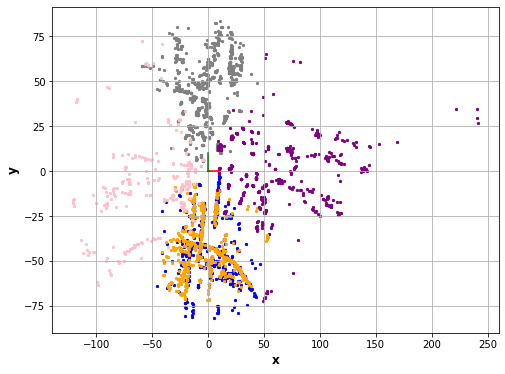

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel("x", fontsize=12, fontweight='bold')
ax.set_ylabel("y", fontsize=12, fontweight='bold')
ax.plot((0, 10), (0, 0), (0, 0), c='red')
ax.plot((0, 0), (0, 10), (0, 0), c='green')
ax.grid()

# Sweep parameter
nsweeps = 6

my_sample = my_sample
reference_channel = 'LIDAR_TOP'

channel = 'RADAR_FRONT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='gray', s=5.0)

channel = 'RADAR_BACK_RIGHT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='blue', s=5.0)

channel = 'RADAR_BACK_LEFT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='orange', s=5.0)

channel = 'RADAR_FRONT_RIGHT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='purple', s=5.0)

channel = 'RADAR_FRONT_LEFT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='pink', s=5.0)

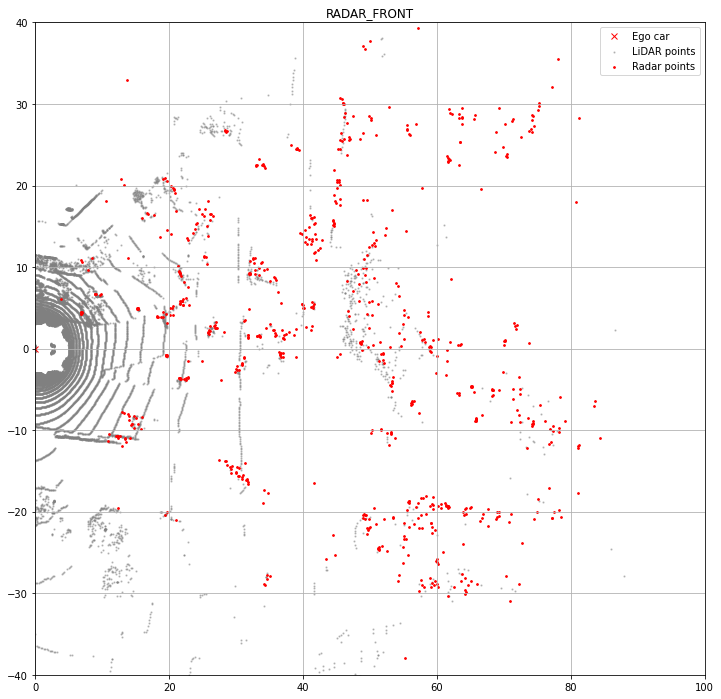

In [9]:
custom_render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=6, underlay_map=True, axes_limit=100)

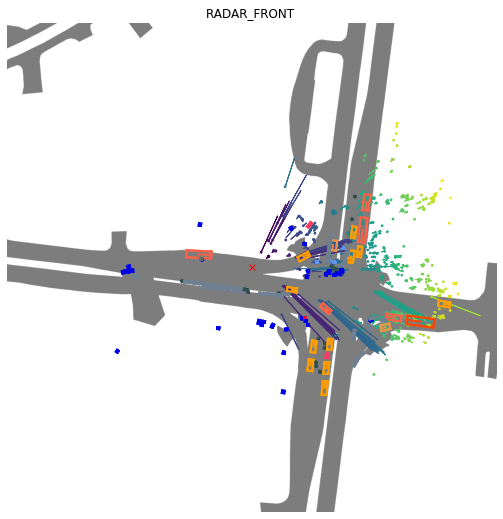

In [10]:
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=6, underlay_map=True, axes_limit=100)

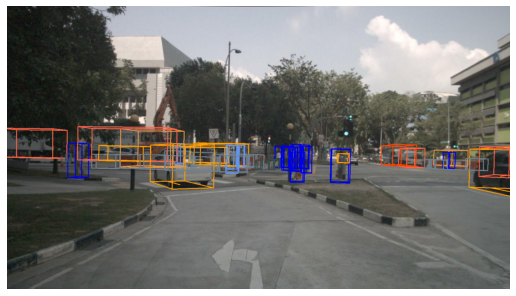

In [11]:
# 投射物件框在影像上
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
fig.canvas.set_window_title('ss')
ax.axis('off')

impath, boxes, camera_intrinsic = nusc.get_sample_data(my_sample['data']['CAM_FRONT'])
im = cv2.imread(impath)
for idx, box in enumerate(boxes):
    c = nusc.colormap[box.name]

    box.render_cv2(im, view=camera_intrinsic, normalize=True, colors=(c, c, c))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

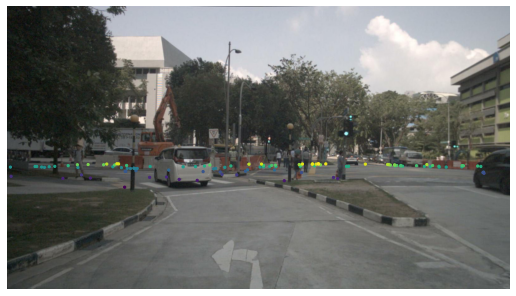

In [12]:
# 投射雷達點在影像上
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

In [13]:
# 在 lidar-top frame上畫出每一個annotation 的位置
# for i in range(len(my_sample['anns'])):
#     nusc.render_annotation(my_sample['anns'][i])

In [14]:
# 迷幻眩光 scene
my_scene_token = nusc.field2token('scene', 'name', 'scene-1100')[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT', imsize=(1280, 720))

## accumulate radar data manually (deprecated)

In [15]:
# sample_rec = my_sample
# channel = 'RADAR_FRONT'

# ref_sd_token = sample_rec['data'][channel]
# ref_sd_rec = nusc.get('sample_data', ref_sd_token)

# sample_data_token = sample_rec['data'][channel]
# current_sd_rec = nusc.get('sample_data', sample_data_token)

# nsweeps = 10
# for _ in range(nsweeps):
#     # Load up the pointcloud and remove points close to the sensor.
#     current_pc = RadarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))
#     current_pc.remove_close(1.0)
    
#     if current_sd_rec['prev'] == '':
#         break
#     else:
#         current_sd_rec = nusc.get('sample_data', current_sd_rec['prev'])
